In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
# 1. Đọc dữ liệu
file_path = 'D:\dow\project\data\iot_equipment_monitoring_dataset.csv'
df = pd.read_csv(file_path)

In [7]:
# 2. Xử lý cột thời gian
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df.drop(columns=['Timestamp'], inplace=True)

# Đưa cột thời gian lên đầu
time_columns = ['Day', 'Month', 'Year', 'Hour', 'Minute']
other_columns = [col for col in df.columns if col not in time_columns]
df = df[time_columns + other_columns]


In [8]:
# 3. Mã hóa Sensor_ID
if 'Sensor_ID' in df.columns:
    df['Sensor_ID'] = df['Sensor_ID'].astype(str).str.extract('(\d+)').astype(int)

# 4. Đưa các cột chuẩn hóa vào đúng vị trí sau Sensor_ID
normalized_cols = [
    'Normalized_Temp', 'Normalized_Vibration', 
    'Normalized_Pressure', 'Normalized_Voltage', 'Normalized_Current'
]
normalized_cols = [col for col in normalized_cols if col in df.columns]  # Kiểm tra tồn tại

sensor_idx = df.columns.get_loc('Sensor_ID')
cols_new = (
    df.columns[:sensor_idx + 1].tolist() +
    normalized_cols +
    [col for col in df.columns if col not in (time_columns + ['Sensor_ID'] + normalized_cols)]
)
df = df[cols_new]

# 5. Loại bỏ các cột gốc
sensor_raw_cols = ['Temperature', 'Vibration', 'Pressure', 'Voltage', 'Current']
df.drop(columns=[col for col in sensor_raw_cols if col in df.columns], inplace=True)


In [9]:
# 6. Mã hóa trực tiếp cột Fault_Type (ghi đè chuỗi thành số)
if 'Fault_Type' in df.columns:
    df['Fault_Type'] = df['Fault_Type'].fillna('Normal')
    fault_type_mapping = {
        'Normal': 0,
        'Electrical Fault': 1,
        'Mechanical Failure': 2,
        'Overheating': 3
    }
    df['Fault_Type'] = df['Fault_Type'].map(fault_type_mapping)

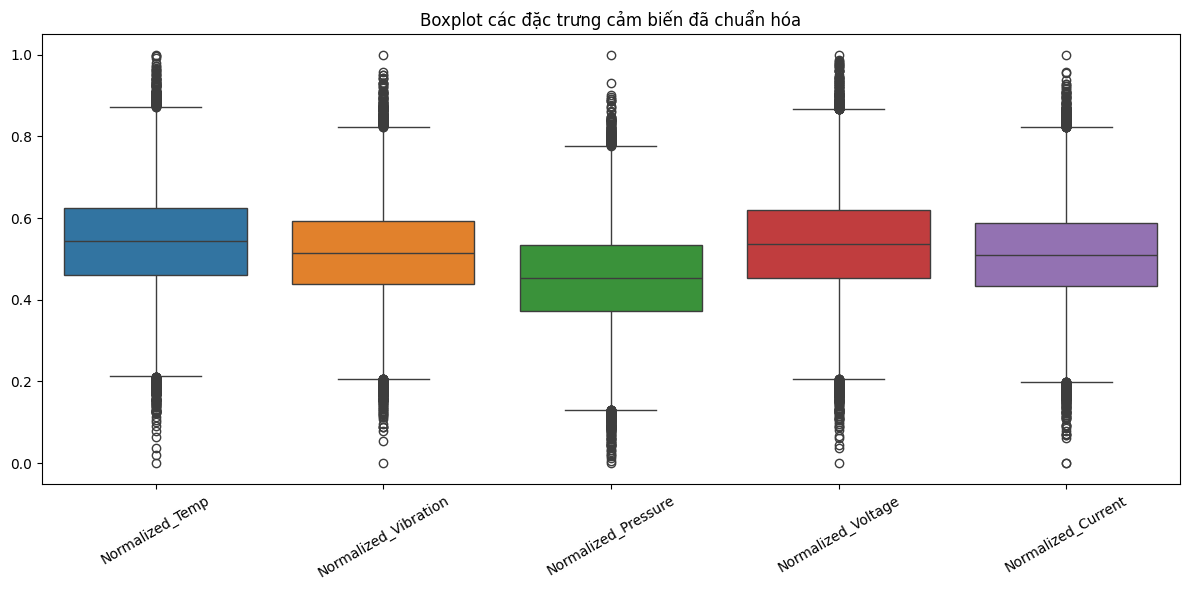

In [10]:
# 7. Vẽ các biểu đồ phân phối dữ liệu (TRƯỚC khi lọc outlier)

# 7.1 Boxplot cho các cột chuẩn hóa
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[normalized_cols])
plt.title("Boxplot các đặc trưng cảm biến đã chuẩn hóa")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

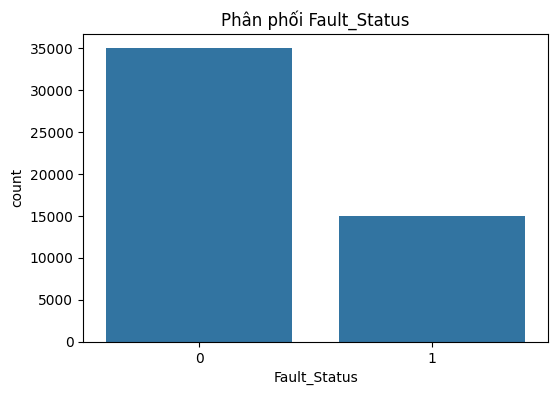

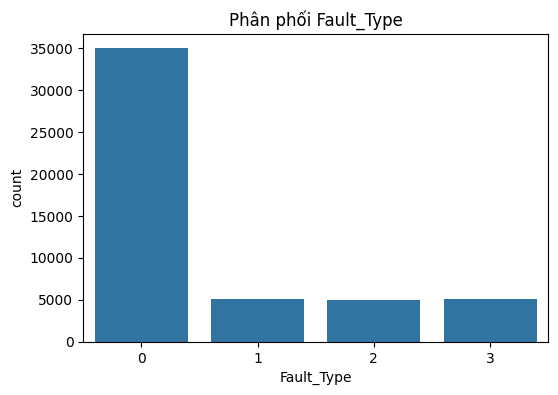

In [11]:
# 7.2 Phân phối nhãn lỗi
plt.figure(figsize=(6,4))
sns.countplot(x='Fault_Status', data=df)
plt.title("Phân phối Fault_Status")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Fault_Type', data=df)
plt.title("Phân phối Fault_Type")
plt.show()

In [12]:
# 8. Lọc outlier bằng IQR cho các cột chuẩn hóa
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower) & (df_clean[column] <= upper)]
    return df_clean

df_no_outliers = remove_outliers_iqr(df, normalized_cols)
print(f"Số dòng sau khi loại outlier: {df_no_outliers.shape[0]}")

Số dòng sau khi loại outlier: 48302


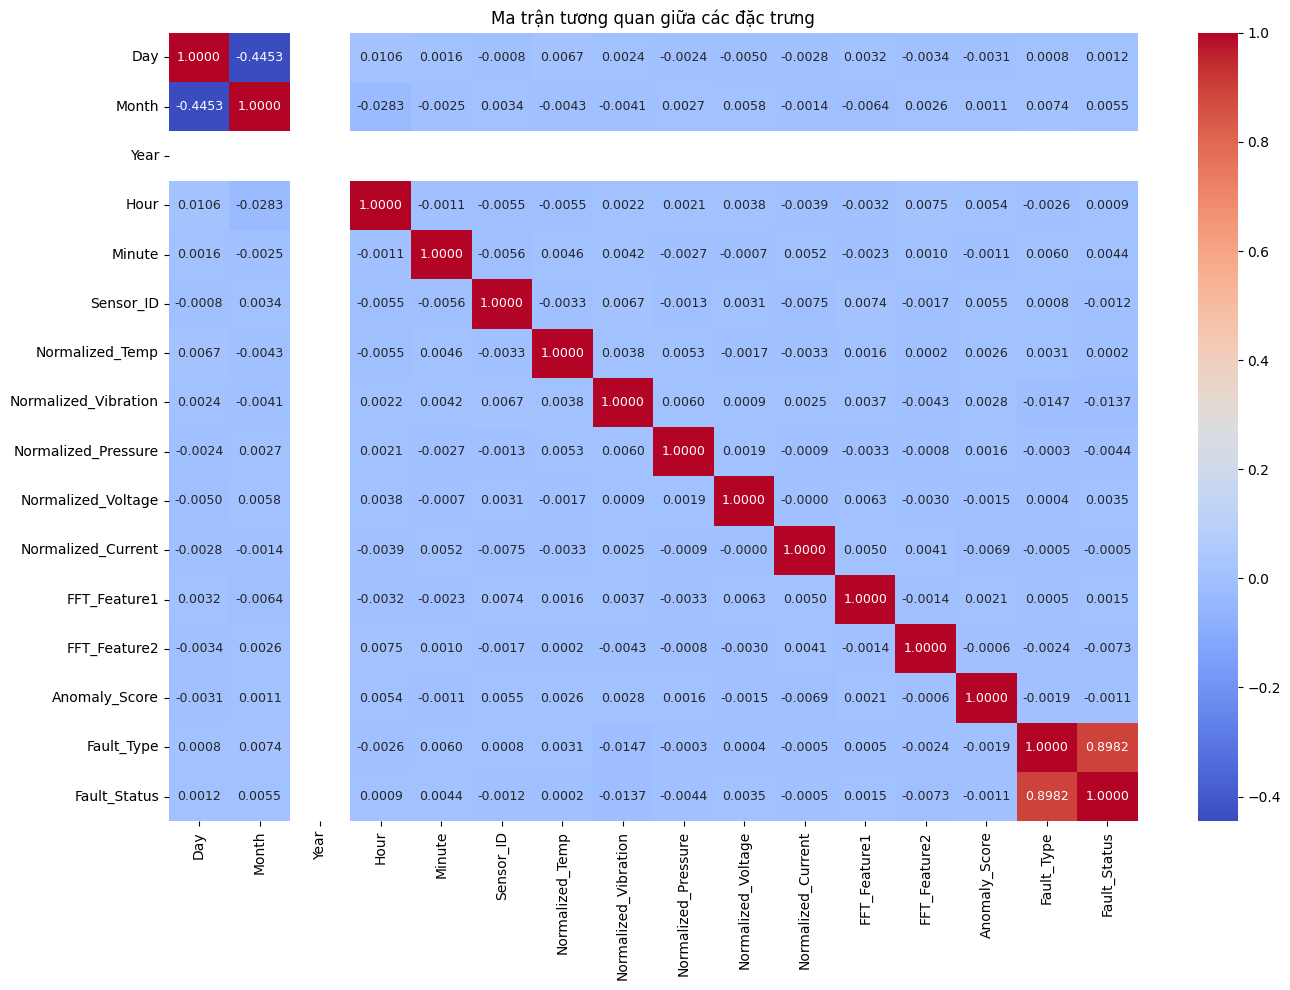

In [13]:
# 9. Vẽ ma trận tương quan cho dữ liệu đã loại outlier
plt.figure(figsize=(14, 10))
corr_matrix = df_no_outliers.corr(numeric_only=True)
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.4f', 
    cmap='coolwarm', 
    annot_kws={"size":9}
)
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.tight_layout()
plt.show()

In [14]:
# 10. Lưu lại file kết quả
save_path = 'D:\dow\project\data\processed_iot_dataset.csv'
df_no_outliers.to_csv(save_path, index=False)
print(f"Đã lưu file {save_path} thành công!")

Đã lưu file D:\dow\project\data\processed_iot_dataset.csv thành công!


In [16]:
df_no_outliers.head(20)

,Day,Month,Year,Hour,Minute,Sensor_ID,Normalized_Temp,Normalized_Vibration,Normalized_Pressure,Normalized_Voltage,Normalized_Current,FFT_Feature1,FFT_Feature2,Anomaly_Score,Fault_Type,Fault_Status
0,1,1,2015,0,0,151,0.524226,0.211423,0.397119,0.800961,0.446526,0.224737,0.093476,0.239856,0,0
1,1,1,2015,0,1,192,0.682771,0.672347,0.240942,0.720230,0.552688,0.973402,0.628513,0.776081,0,0
2,1,1,2015,0,2,114,0.502817,0.379318,0.565941,0.686405,0.524917,0.566625,0.417355,0.039005,0,0
3,1,1,2015,0,3,171,0.463947,0.506990,0.460380,0.608896,0.520069,0.872516,0.926135,0.584953,0,0
5,1,1,2015,0,5,120,0.533576,0.468284,0.315559,0.637810,0.556101,0.223781,0.931844,0.315629,1,1
6,1,1,2015,0,6,182,0.396325,0.545097,0.556369,0.533311,0.389735,0.511208,0.505407,0.201581,0,0
7,1,1,2015,0,7,186,0.763817,0.609110,0.520539,0.619743,0.645674,0.664680,0.090581,0.093058,0,0
8,1,1,2015,0,8,174,0.466658,0.518525,0.388046,0.692111,0.755032,0.771670,0.830049,0.427642,0,0
9,1,1,2015,0,9,174,0.655647,0.665214,0.608958,0.664129,0.275733,0.778030,0.617262,0.740787,2,1
10,1,1,2015,0,10,187,0.645224,0.596465,0.328063,0.602701,0.285437,0.969658,0.656050,0.633778,0,0
